# 2. &nbsp; Irreversible switch

Differentiation processes are based on binary decisions which are often irreversible. The previous reaction scheme can be extended by a positive feedback loop that turns the switch-like response into an irreversible decision.

We again look at an extended scheme (not shown here) with an enzyme $E$ affected by the response. Here, the signal $S$ induces a response $R$, which by itself activates the conversion of species $E$ into its active form $E^*$. $E^*$ leads to further production of $R$. This mutual activation results in a positive feedback. It is again assumed that the total amount of enzyme is conserved, meaning $E + E^* = E_T$.

<div style="display: flex; justify-content: space-around;">
<div style="width: 30%;">

$$
\text{Rate equation scheme}
$$

$$
\text{NOT PROVIDED}
$$

</div>
<div style="width: 60%;">

$$
\text{System of ODEs}
$$

$$
\begin{align*}
\text{I}. & \quad \dot{[R]} = k_p + k_0 [E^*] + k_1 [S] - k_2 [R] \\
\text{II}. & \quad \dot{[E^*]} = k_3 [R] \frac{[E_T] - [E^*]}{K_{M3} + [E_T] - [E^*]} - k_4 \frac{[E^*]}{K_{M4} + [E^*]}
\end{align*}
$$

</div>
</div>

The set of ODEs was implemented with initial conditions $R(0) = E^*(0) = 0$. Parameter values are $k_0 = 0.4$, $k_1 = 0.01$, $k_2 = 1$, $k_3 = 1$, $k_4 = 0.2$, $K_{M3} = 0.4$, $K_{M4} = 0.4$ and $E_T = 1$. The dynamics of $R$ and $E^*$ were plotted for $S = 2.5$.

Now, we solve the equations for the signal range $0 \leq S \leq 5$. We start with $S = 0$ and increase the concentration in increments of $0.1$ once the system reached steady state. We observe how the steady state value of $R$ depends on $S$. The simulations are repeated starting with $S = 5$ and reducing the signal in increments of $0.5$ to zero.

In [52]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
# FIGURE INITIALIZATION
fig = plt.figure(figsize=(12, 8), dpi=300)
gs = plt.GridSpec(2, 2)

# GENERAL PARAMETERS
t_span = [0, 400]  # time span
t_eval = np.linspace(*t_span, 2000)  # time points for plotting

In [54]:
def ode(t, y, k_0, k_1, k_2, k_3, k_4, K_M3, K_M4, E_T, S):
    dydt = np.array([
        k_0 * y[1] + k_1 * S - k_2 * y[0],
        k_3 * y[0] * (E_T - y[1]) / (K_M3 + E_T - y[1]) - k_4 * (y[1]) / (K_M4 + y[1])
    ])
    return dydt


def goldbeter_koshland(u_1, u_2, J_1, J_2):
    B = u_2 - u_1 + J_1 * u_2 + J_2 * u_1
    return (2 * u_1 * J_2) / (B + np.sqrt(B**2 - 4 * (u_2 - u_1) * u_1 * J_2))


def ode_gk(t, y, k_0, k_1, k_2, k_3, k_4, K_M3, K_M4, E_T, S):
    dydt = np.zeros([1, 1])
    E_p = goldbeter_koshland(k_3*y[0], k_4, K_M3/E_T, K_M4/E_T) * E_T
    dydt[0] = k_0 * E_p + k_1 * S - k_2 * y[0]
    return dydt

In [55]:
# PARAMETERS VALUES
k_0 = 0.4
k_1 = 0.01
k_2 = 1
k_3 = 1
k_4 = 0.2
K_M3 = 0.4
K_M4 = 0.4
E_T = 1  # total enzyme concentration

p = [k_0, k_1, k_2, k_3, k_4, K_M3, K_M4, E_T, 0]  # parameter vector, leave S = 0 for now

# INITIAL CONDITIONS
y0 = [0, 0]  #  initial conditions for R, E*
y0_gk = [0]  # initial condition for Goldbeter-Koshland approximation
t_total = 0  # to keep track of time

min_S = 0
max_S = 4

# ARRAYS TO STORE RESULTS
S_full = np.zeros([1, 1])
R_full = np.zeros([1, 1])
R_full_gk = np.zeros([1, 1])
E_full = np.zeros([1, 1])
t_full = np.zeros([1, 1])

# ASCENDING SIGNAL
S_asc = np.linspace(min_S, max_S, int((max_S - min_S) / 0.1) + 1)  # signal range
R_ss_asc = np.zeros_like(S_asc)
R_ss_gk_asc = np.zeros_like(S_asc)

for i in range(len(S_asc)):
    p[-1] = S_asc[i]  # set current signal strength
    # Solve ODE numerically and update arrays:
    results = solve_ivp(ode, t_span, y0, t_eval=t_eval, args=p)
    R_ss_asc[i] = results.y[0, -1]  # get final value of R for current signal
    R_full = np.append(R_full, results.y[0])
    E_full = np.append(E_full, results.y[1])
    t_full = np.append(t_full, results.t + t_total)
    S_full = np.append(S_full, np.full_like(results.t, S_asc[i]))
    t_total += results.t[-1]
    # Compute Goldbeter-Koshland approximation for previous numerical solution:
    gk = solve_ivp(ode_gk, t_span, y0_gk, t_eval=t_eval, args=p)
    R_ss_gk_asc[i] = gk.y[0, -1]
    R_full_gk = np.append(R_full_gk, gk.y[0])
    # Update initial conditions:
    y0 = results.y[:, -1]
    y0_gk = gk.y[:, -1]

# DESCENDING SIGNAL
S_desc = np.linspace(max_S, min_S, int((max_S - min_S) / 0.5) + 1)  # signal range
R_ss_desc = np.zeros_like(S_desc)
R_ss_gk_desc = np.zeros_like(S_desc)

for i in range(len(S_desc)):
    p[-1] = S_desc[i]  # set current signal strength
    # Solve ODE numerically and update arrays:
    results = solve_ivp(ode, t_span, y0, t_eval=t_eval, args=p)
    R_ss_desc[i] = results.y[0, -1]  # get final value of R for current signal
    R_full = np.append(R_full, results.y[0])
    E_full = np.append(E_full, results.y[1])
    t_full = np.append(t_full, results.t + t_total)
    S_full = np.append(S_full, np.full_like(results.t, S_desc[i]))
    t_total += results.t[-1]
    # Compute Goldbeter-Koshland approximation for previous numerical solution:
    gk = solve_ivp(ode_gk, t_span, y0_gk, t_eval=t_eval, args=p)
    R_ss_gk_desc[i] = gk.y[0, -1]
    R_full_gk = np.append(R_full_gk, gk.y[0])
    # Update initial conditions:
    y0 = results.y[:, -1]
    y0_gk = gk.y[:, -1]

In [ ]:
ax = fig.add_subplot(gs[0, 0])
ax.plot(S_asc, R_ss_asc, label="$R_{SS}$", color="tab:orange")
ax.plot(S_asc, R_ss_gk_asc, label="$R_{SS, GK}$", color="tab:green", linestyle="dashed", dashes=(3,3))  # Goldbeter-Koshland approximation
ax.set_title("Steady state response of the irreversible switch (ascending signal)")
ax.set_xlabel("Signal strength")
ax.set_ylabel("Steady state response $R_{SS}$")
ax.legend()

ax = fig.add_subplot(gs[0, 1])
ax.plot(S_desc, R_ss_desc, label="$R_{SS}$", color="tab:orange")
ax.plot(S_desc, R_ss_gk_desc, label="$R_{SS, GK}$", color="tab:green", linestyle="dashed", dashes=(3,3))  # Goldbeter-Koshland approximation
ax.set_title("Steady state response of the irreversible switch (descending signal)")
ax.set_xlabel("Signal strength")
ax.set_ylabel("Steady state response $R_{SS}$")
ax.legend()

ax = fig.add_subplot(gs[1, :])
ax.plot(t_full, R_full, label="$R$", color="tab:orange", linewidth=2)
ax.plot(t_full, R_full_gk, label="$R_{GK}$", color="tab:green", linewidth=1)  # Goldbeter-Koshland approximation
ax.set_xlim([t_full[0], t_full[-1]])
ax.set_title("Full response of the irreversible switch (ascending | descending signal)")
ax.set_xlabel("Time $t$")
ax.set_ylabel("Response $R$")

ax2 = ax.twinx()
ax2.plot(t_full, S_full, label="$S$", color="tab:blue")
ax2.axvline((int((max_S-min_S)/0.1)+1)*400, color="black", linewidth=1)
ax2.set_ylabel("Signal $S$")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines2 + lines, labels2 + labels)

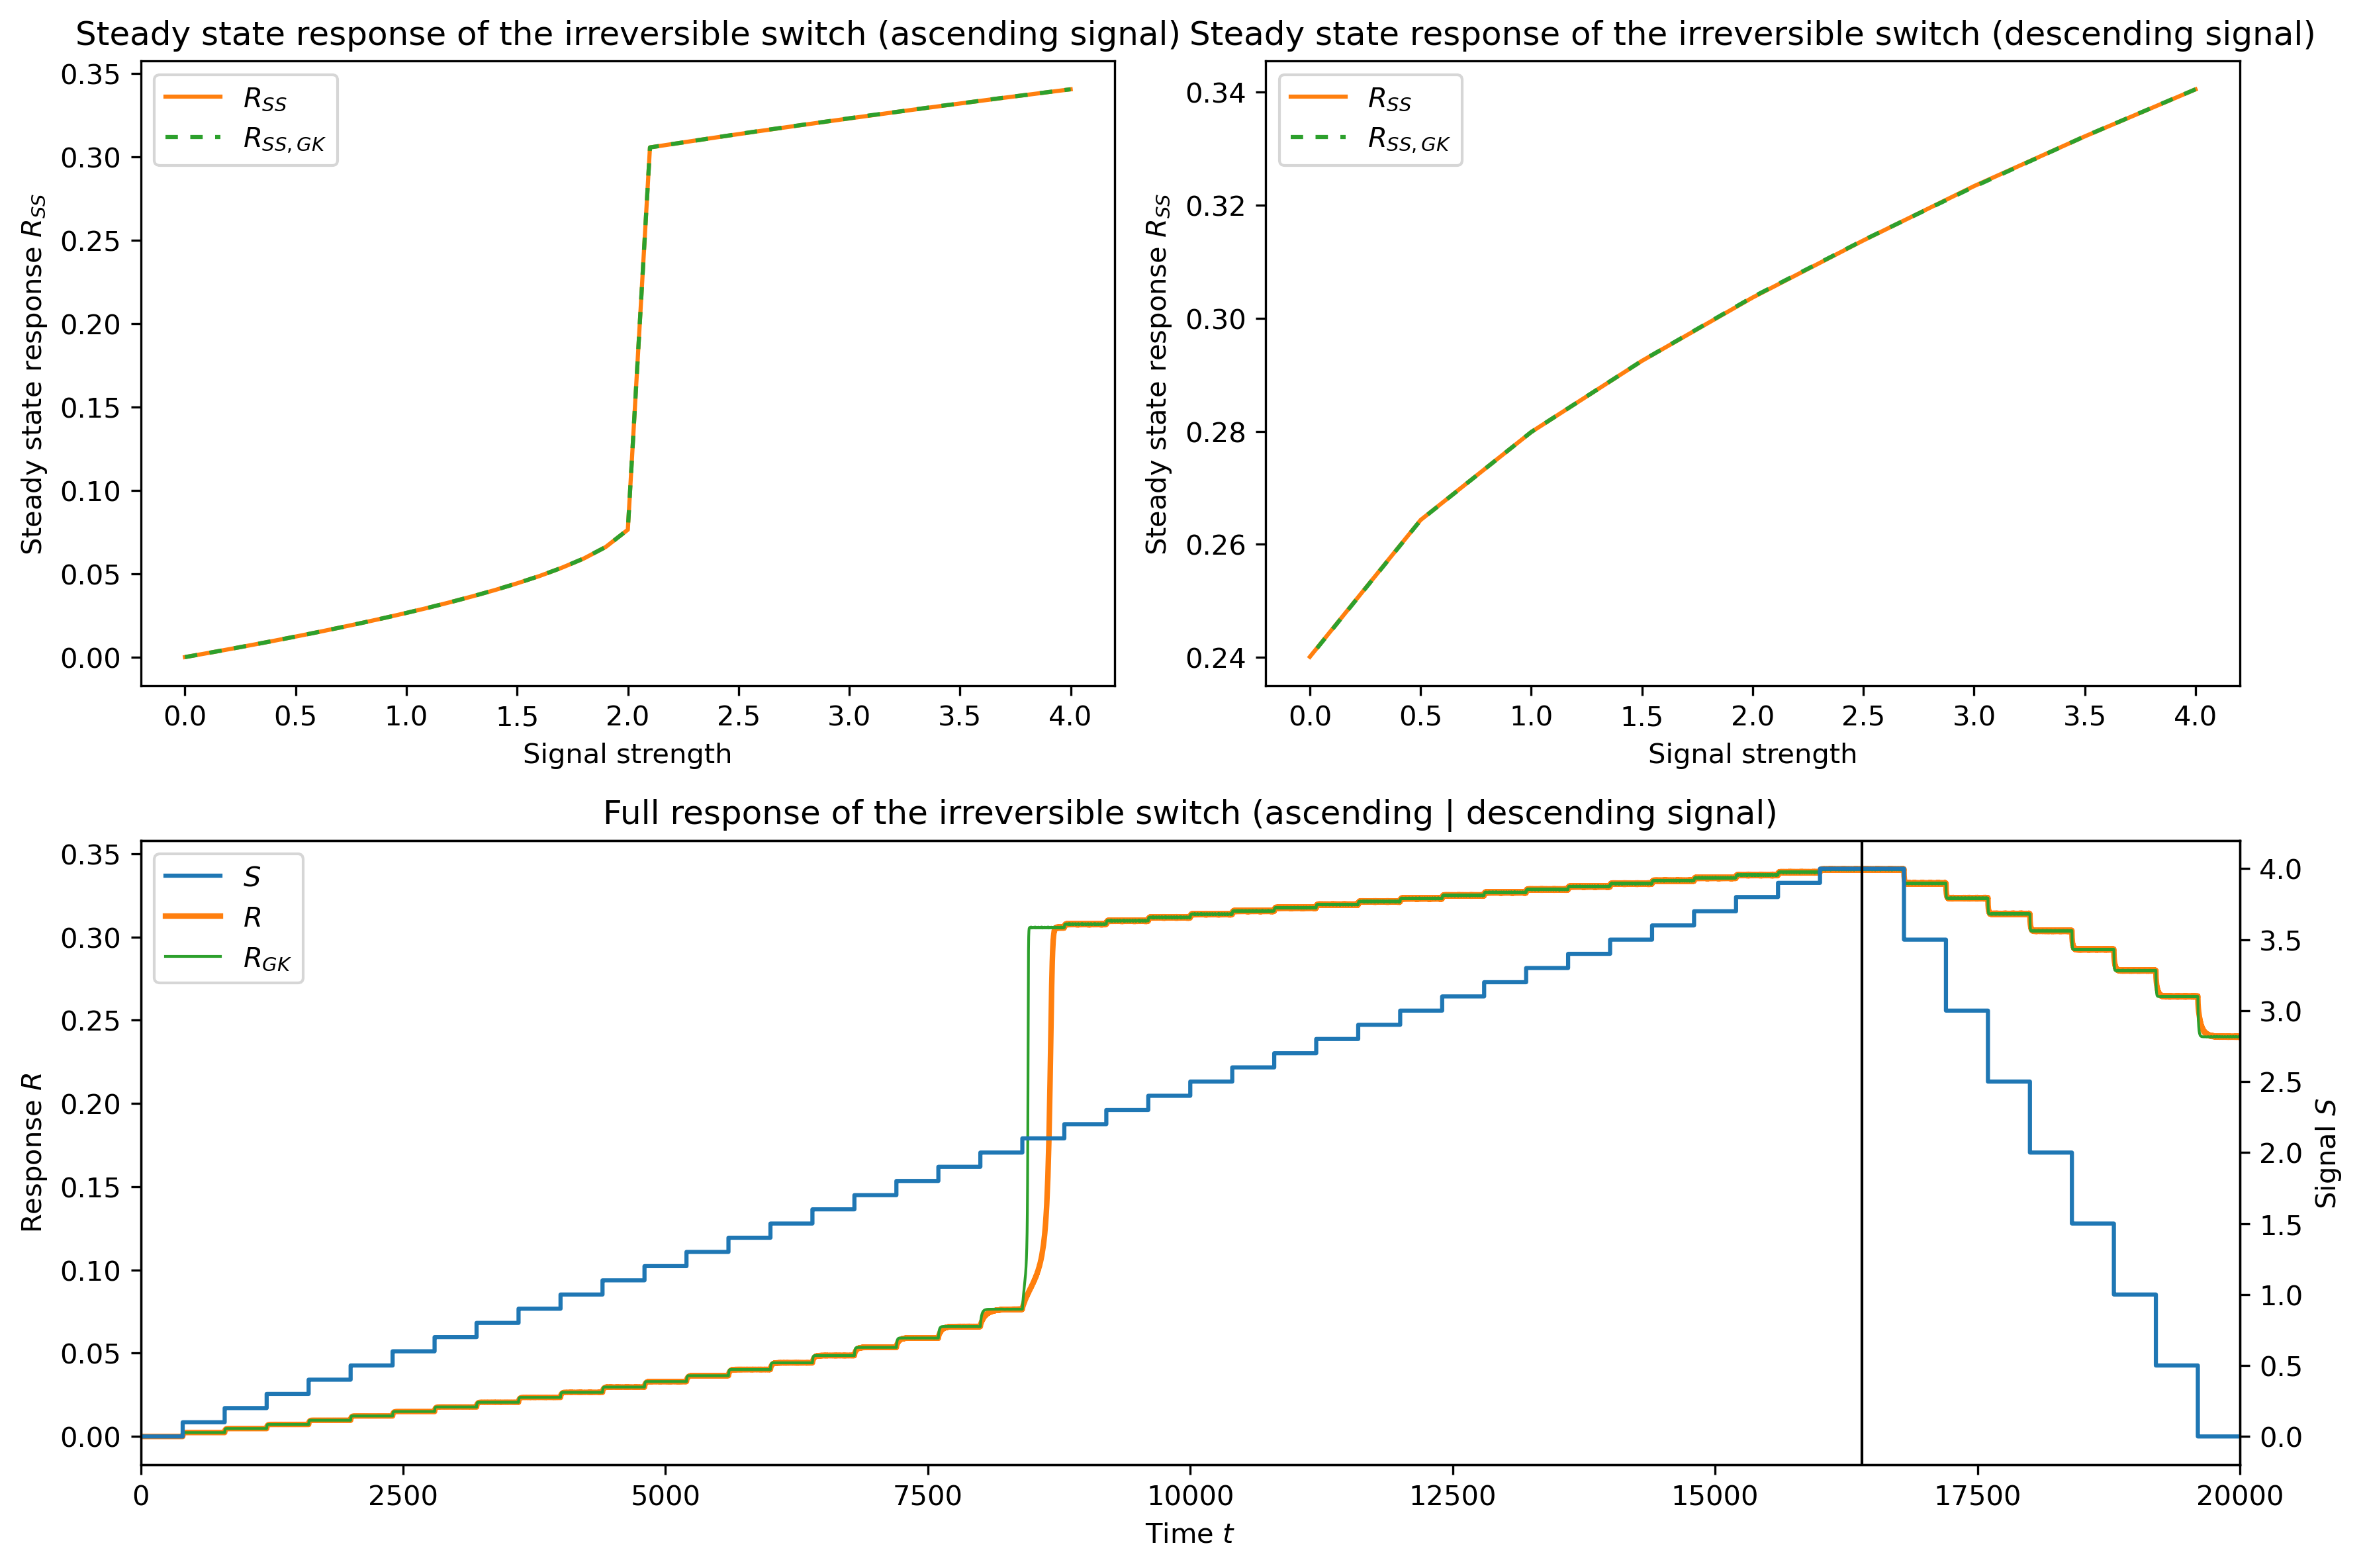

In [57]:
# PLOT THE FIGURE
fig.tight_layout()
fig

Looking at the steady-state response $R$ for increasing signal strenghts $S$, we can see that the response $R$ initially increases roughly linearly, until a signal threshold is reached, where a jump is observed, before the response only slightly increases further with the increase of the signal $S$, where a slight linear dependence can be observed again.  When plotting the full solution instead of only the presumed steady-state value (bottom) an integration time of $400$ was used for each step, because otherwise the time interval would be too short to reach a steady state for all signal concentrations.

If the signal strength is decreased (top right), so looking at the graph from right to left, the low initial steady-state response $R_{SS}$ levels cannot be reached anymore as a result of the irreversibility of the switch (because of its positive feedback loop). This means that the system is bistable for signal concentrations $S$ between $0$ and $2$, which means that there are two possible steady states, making the history (or initialization) of $R$ the deciding factor on which steady state can be reached.

When the Goldbeter-Koshland approximation is used instead, there is only a differential equation for $R$, with the one for $E^*$ only being implied. While the steady-state solution is almost identical to the numerical one (top), a deviation can be observed in the intermediate values (especially at larger jumps), both before and after the threshold is reached, but especially at the threshold itself. Because of the steeply rising response curve, the GK assumption of $E$ being in a quasi-steady state relative to $R$ does not hold.